In [1]:
import pandas as pd

In [25]:
# Create a csv file for each train in the in the dataset
df = pd.read_csv('../assets/processed.csv', sep=';')

# Group by train
grouped = df.groupby('mapped_veh_id')

# Iterate over each train
for train_id, train_df in grouped:
    # Save the train in a csv file
    train_df.to_csv(f'../assets/trains/{int(train_id)}.csv', sep=';', index=False)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
data = pd.read_csv('../assets/trains/102.csv', sep=';')
# Sort by timestamps_UTC
timestamp_col = 'timestamps_UTC'
data[timestamp_col] = pd.to_datetime(data[timestamp_col])
data = data.sort_values(by=timestamp_col)
# Remove data when consecutive timestamps delta is bigger than 30min
data = data[data[timestamp_col].diff() < pd.Timedelta(minutes=30)]

In [3]:
AirTemp = data['RS_E_InAirTemp_PC2']
Timestamps = data['timestamps_UTC']

ts = pd.Series(AirTemp.values, index=Timestamps)
ts = ts[500:10000]

# Normalize the data between 0 and 1
ts = (ts - ts.min()) / (ts.max() - ts.min())

In [ ]:
import tensorflow as tf
from keras.src.layers import LSTM, TimeDistributed, Dense
from keras.src.layers import Dropout
from keras.src.layers import RepeatVector
from keras import Sequential
import numpy as np
import pandas as pd

# Assuming normalized_ts is your normalized time series
sequence_length = 30

# Function to create sequences
def create_sequences(values, time_steps=sequence_length):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# Create sequences
x_train = create_sequences(ts)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = Sequential([
    LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    RepeatVector(x_train.shape[1]),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(x_train.shape[2]))
])

model.compile(optimizer='adam', loss='mae')

# Train the model
model.fit(x_train, x_train, epochs=10, batch_size=32, validation_split=0.1)

# Anomaly detection
x_train_pred = model.predict(x_train)
x_train_pred
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [11]:
# Detect all the samples which are anomalies
anomalies = train_mae_loss > 2 * np.std(train_mae_loss)

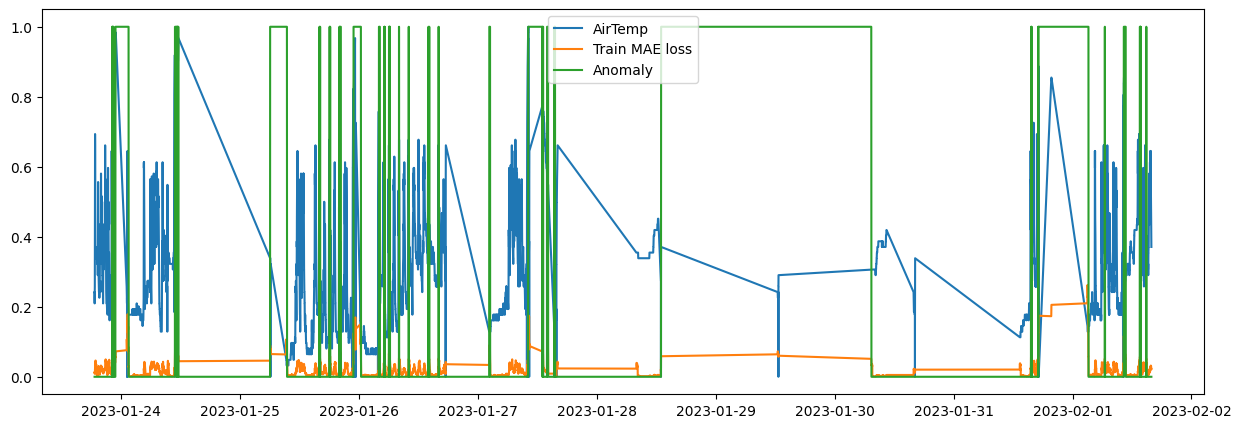

In [12]:
# Plot anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(ts[sequence_length:].index, ts[sequence_length:], label='AirTemp')
plt.plot(ts[sequence_length:].index, train_mae_loss, label='Train MAE loss')
plt.plot(ts[sequence_length:].index, anomalies, label='Anomaly')

plt.legend()


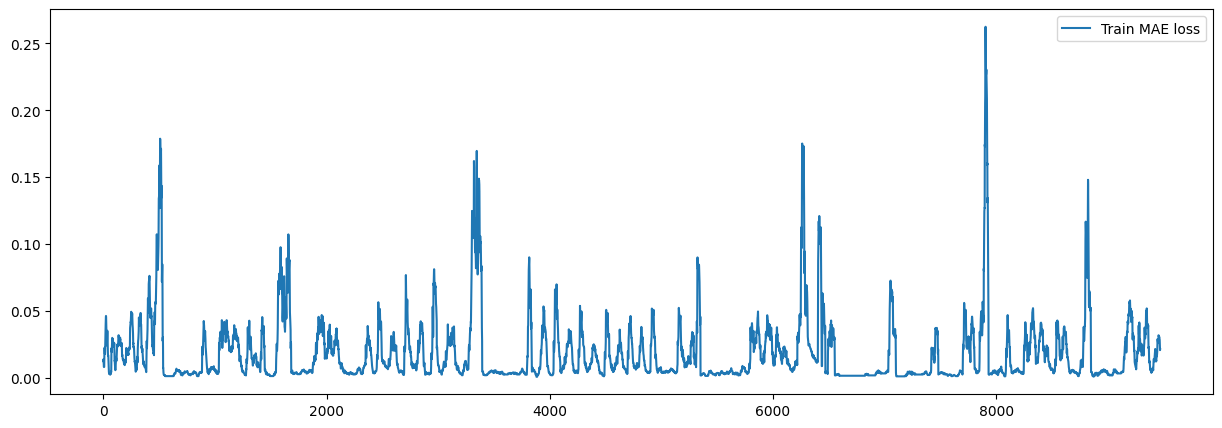

In [5]:
# Plot loss
plt.figure(figsize=(15, 5))
plt.plot(train_mae_loss, label='Train MAE loss')

plt.legend()


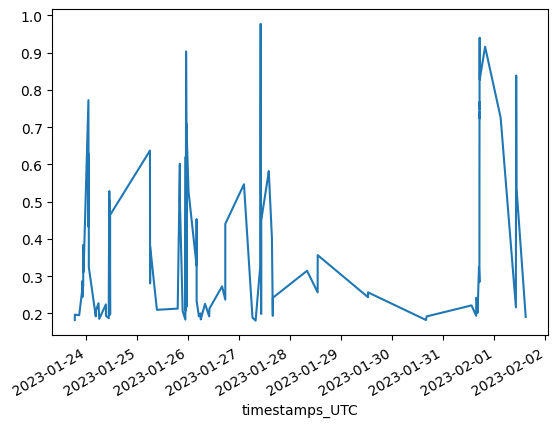

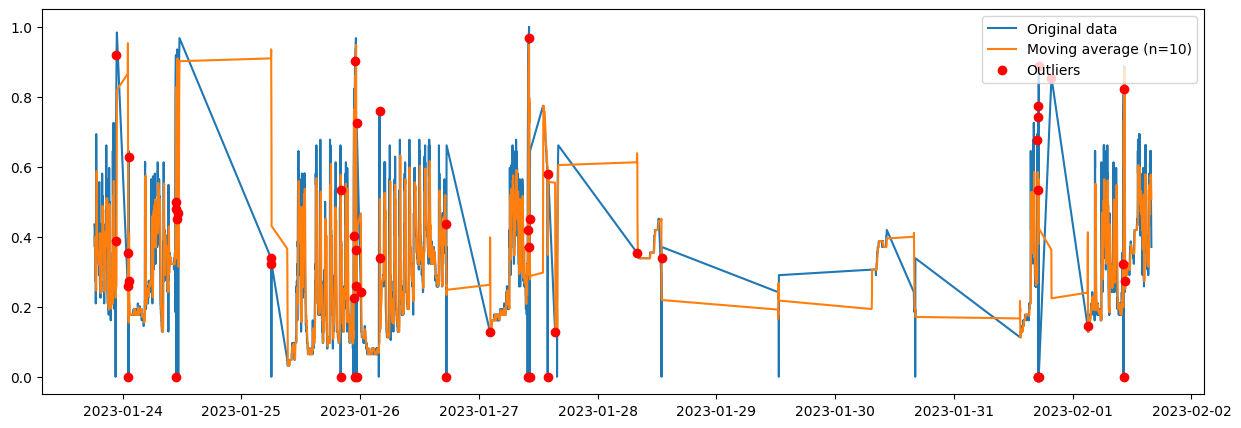

In [6]:
from processing.outliers.moving_average import moving_average
from processing.outliers.outliers import compute_outliers

# Use moving average to detect outliers
window_size = 10
# Compute moving average of moving average
ts_ma = moving_average(ts, window_size)
compute_outliers(ts_ma, ts).plot()

# Compute difference between moving average and initial data
diff = ts_ma - ts
# Compute derivative of difference
diff = diff.diff()
#Absolute value of derivative
diff = diff.abs()
# Now plot the original data and the moving average, along with the outliers
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts, label='Original data')
plt.plot(ts_ma.index, ts_ma, label='Moving average (n=%d)' % window_size)
# plot arima

# When the derivative is bigger than 0.1, we have an outlier
plt.plot(diff[diff > 0.3].index, ts[diff > 0.3], 'ro', label='Outliers')
plt.legend(loc='best')